### Install and import packages

In [ ]:
# Install packages
!pip install bayes_logistic

In [2]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_list = ["Green", "Blue"]
color_map = mcolors.ListedColormap(["Green", "Blue"])

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule, PyroSample

### Set parameters

In [3]:
# Set parameters
# num_data
num_data = 10
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 1000

# data_x marginal distribution parameters
data_x_marginal_params = [
    [[1.0, 5.0], [(1.0, 0.0), (0.0, 1.0)]],
    [[-5.0, 1.0], [(3.0, 0.0), (0.0, 3.0)]]]

# weights prior distribution parameters
weights_prior_params = [[0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]]]

# init sigma used in numerical optimization for laplace approximation
laplace_init_sigma = 0.01
laplace_num_iters = 1000


### Generate data_x

$$
\begin{align*}
  \mathrm{data}\_x &= [c_0\_x, c_1\_x]\\
  c_0\_x &\sim p(x|\mu_0, \sigma_0^2) \\
  c_1\_x &\sim p(x|\mu_1, \sigma_1^2)
\end{align*}
$$


In [4]:
# Generate data_x
# data_x_marginal_dists = [
#     stats.multivariate_normal(mu, sigma, seed=12345) \
#         for mu, sigma in data_x_marginal_params]

# c0_x = data_x_marginal_dists[0].rvs(size=(num_data_half))
# c1_x = data_x_marginal_dists[1].rvs(size=(num_data_half))
# data_x = np.vstack((c0_x, c1_x))

data_x = np.random.randn(num_data, num_feats)
print(data_x.shape)

(10, 2)


### Sample weights, generate sample y from sample weights and visualize data

#### Comments on the plots
1. Even though the data_x is set to be linearly separable, using random prior weights can lead to linearly nonseparable cases.

### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [ ]:
### Generate prior and posterior samples

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)

def logistic_regression_model(x, y):
    num_data, num_feats = x.shape
    # set prior  
    w = pyro.sample("w", dist.MultivariateNormal(
        torch.tensor(weights_prior_params[0], dtype=torch.float).reshape(1, num_feats),
        torch.tensor(weights_prior_params[1], dtype=torch.float)).to_event(1))
    
    # compute ymean and sample
    ymean = torch.sigmoid(torch.matmul(x, w.squeeze(1).T)).squeeze(-1)
    with pyro.plate("data", x.shape[0]):
        pyro.sample("y", dist.Bernoulli(ymean), obs=y)
        
nuts_kernel = pyro.infer.NUTS(logistic_regression_model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1, warmup_steps=100, disable_progbar=True)

samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
for i in range(10):
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    # print(sample_a_y.shape)
    # stop

    # sample weights' posterior
    # torch.cuda.empty_cache()
    pyro.clear_param_store()
    mcmc.run(torch.tensor(data_x, dtype=torch.float), torch.tensor(sample_a_y, dtype=torch.float))
    sample_a_weights_posterior = mcmc.get_samples()["w"].reshape(1, num_feats)
    samples_a_weights_posterior.append(sample_a_weights_posterior.data.cpu().numpy())  
    del mcmc_samples
     

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
print(samples_b_weights_prior.shape)
print(samples_a_weights_posterior.shape)

### Visualize the generated prior and posterior samples 

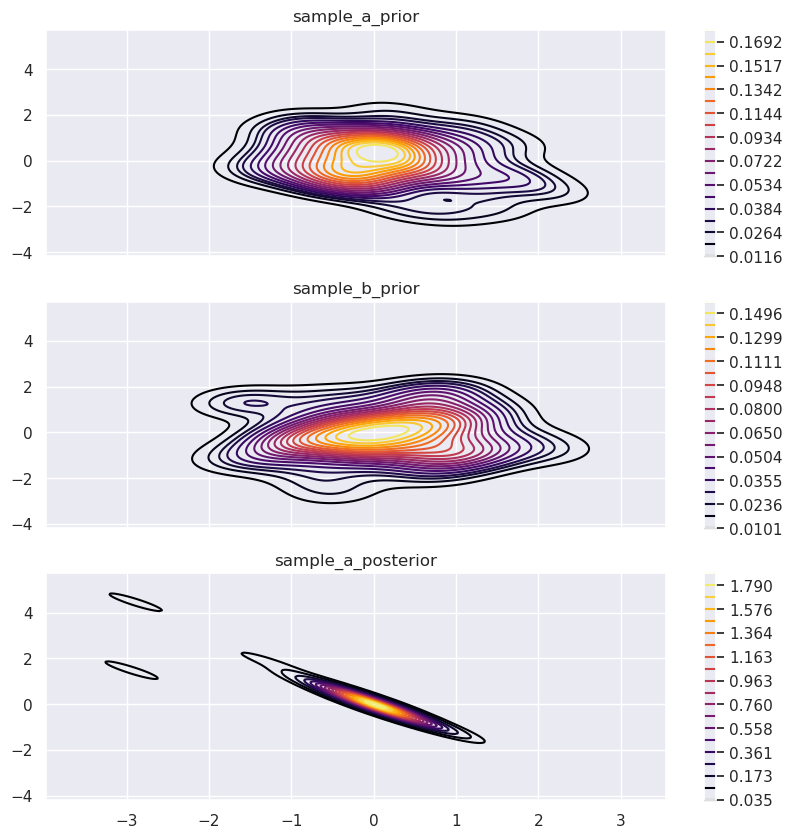

In [30]:
# Visualize the generated prior and posterior samples 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
            cmap="inferno", shade=False, cbar=True, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
            cmap="inferno", shade=False, cbar=True, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
            cmap="inferno", shade=False, cbar=True, ax=axes[2])
axes[0].set_title("sample_a_prior")
axes[1].set_title("sample_b_prior")
axes[2].set_title("sample_a_posterior")
plt.show()

#### Comments on the plots
1. In 2d, the posterior samples are quite different from the prior samples 